# Setup #

In [1]:
# Make sure these libraries are installed on local computer
from qiskit import *
from qiskit import IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.tools.monitor import job_monitor
from qiskit.providers.ibmq import least_busy

import cv2
from PIL import Image
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('bmh')

import os
import math

# Resource Estimation
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.aer import AerSimulator
from qiskit import IBMQ
from qiskit.compiler import transpile
from time import perf_counter

# Detection algorithm works with an NxN matrix
#N is a power of 2
N = 32

#Name the image
name = "Sunny_Capybara"

#Path of image to use
# path = os.path.join("test_images", "squarecapybara.jpg")
path = os.path.join("test_images", "timothycapybara.png")
# path = os.path.join("test_images", "fire.png")
# path = os.path.join("test_images", "flower.png")
# path = os.path.join("test_images", "bulb.png")
# path = os.path.join("test_images", "gradient.png")

# Helper Functions #

In [2]:
def plot_image(img, title: str):
    plt.title(title)
    
    if img.shape[0] <= 32:
        plt.xticks(range(img.shape[0]))
        plt.yticks(range(img.shape[1]))
    
    plt.imshow(img, extent=[0, img.shape[0], img.shape[1], 0], cmap='viridis')
    plt.show()

In [457]:
def RMS(img_data):
    return np.sqrt(np.sum(img_data**2))

For [QPIE](#QPIE), we're encoding each pixel value into amplitudes of the quantum state. As a result, we need

$\sum _{} ^{} c_i^2 = 1$, since all probabilities must add up to one.

To accomplish this while maintaining relative differences, we set

$c_i = \frac{c_i}{\sqrt{\sum c_i ^2}}$ (Divide by Root mean squared)

so now 

$\sum _{} ^{} (\frac{c_i}{\sqrt{\sum c_i ^2}})^2 = \frac{1}{\sum _{} ^{} c_i^2} \cdot \sum _{} ^{} c_i^2 = 1$, as desired


In [458]:
#Normalize -- squared amplitudes must sum to 1
def amplitude_encode(img_data):

    # Calculate the RMS value
    rms = RMS(img_data)

    # Create normalized image
    image_norm = []
    for arr in img_data:
        for ele in arr:
            image_norm.append(ele / rms)
        
    # Return the normalized image as a numpy array
    return np.array(image_norm)

# Image Preprocessing #

In [459]:
#Input Processing to np array

img_raw = np.asarray(Image.open(path), dtype=int)
# img_raw = plt.imread('/test_images/test_image1.jpg')

n = img_raw.shape[0]
m = img_raw.shape[1]
#n, m, k = img_raw.shape

print('Raw Image info:', img_raw.shape)
print('Raw Image datatype:', img_raw.dtype)

if n != m:
    raise Exception("Image must be square")

if n % N != 0:
    raise Exception(f"Image cannot be converted to an {N} by {N} matrix")

# we need to "reduce" each sz X sz grid
# sz is size
sz = n // N


Raw Image info: (32, 32, 4)
Raw Image datatype: int32


<function <lambda> at 0x7fdf343460d0>


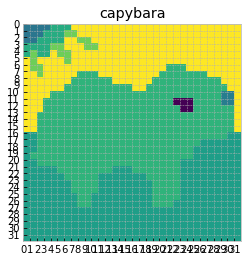

In [460]:
img = np.zeros(shape=(N, N))

for i in range(0, n, sz):
    for j in range(0, n, sz):
        #This will be a single cell in final pixel - use average
        val = np.sum(img_raw[i:i+sz, j:j+sz][0]) / sz / sz
        img[i//sz][j//sz] = val

plot_image(img, "capybara")

$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$
$\newcommand{\bra}[1]{\left\langle{#1}\right|}$
$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$

In [QPIE](#QPIE), we're indexing the grid as $\ket{\text{Img}} = \sum _{i=0} ^{2^n-1} grid[\frac{i}{N}][i \mod N] \ket{i}$.

Therefore, if we obtain differences between adjacent indicies, it will only obtain horizontal differences:

![Horizontal Grid Differences](https://github.com/timothygao8710/Capybaras-Capstone-Project/blob/main/explanation_diagrams/scuffed_HDiff.png?raw=true)

(the red indicates the differences)

In order to obtain all differences for the entire 2D grid, one solution is to simply take the transpose the image, then apply the entire algorithm to both images.

![Vertical Grid Differences](https://github.com/timothygao8710/Capybaras-Capstone-Project/blob/main/explanation_diagrams/scuffed_VDiff.png?raw=true)

When we combine both images together at the end we will now have adjacent differences both vertically and horizontally.

In [461]:
# Horizontal: Original image
image_norm_h = amplitude_encode(img)

# Vertical: Transpose of Original image
image_norm_v = amplitude_encode(img.T)

# Quantum Part - Algorithm #

<a id='QPIE'></a>
## Quantum Probability Image Encoding (QPIE) ##

### Based on [Paper](https://arxiv.org/pdf/2012.11036.pdf) ###

$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$
$\newcommand{\bra}[1]{\left\langle{#1}\right|}$
$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$

Basic idea:

Recall each element in our processed image grid represents the color intensity in that cell.

Let's assign $c = grid[i][j]$, and index of $c$ as $i * N + j$.

In QPIE representation, the image becomes 

$\ket{\text{Img}} = \sum _{i=0} ^{2^n-1} c_i \ket{i}$ or $\ket{\text{Img}} = \sum _{i=0} ^{2^n-1} grid[\frac{i}{N}][i \mod N] \ket{i}$ (n is number of qubits)

This means that we need $n = \lceil \log_2N^2 \rceil$ qubits in order to index all $N^2$ pixels in our image.

In order to actually achieve the desired amplitudes ($c$) for all quantum states states, we can use a combination of CNOT and Aritrary Rotation Gates.

For example, to encode (0, 128, 192, 255):

![quantum state preparation](https://qiskit.org/textbook/ch-applications/images/state_prep.png)

Quiskit has a nice implementation of this algorithm for us [here](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.initialize.html), which we can call through .initialize() on the QuantumCircuit.

Time complexity: $\mathcal{O}(n)$ = $\mathcal{O}(log(N^2))$

In [462]:
# qubit amount
# data_qb should be math.ceil(math.log2(N))
data_qb = math.ceil(math.log2(N**2))
anc_qb = 1
total_qb = data_qb + anc_qb

print(total_qb)

11


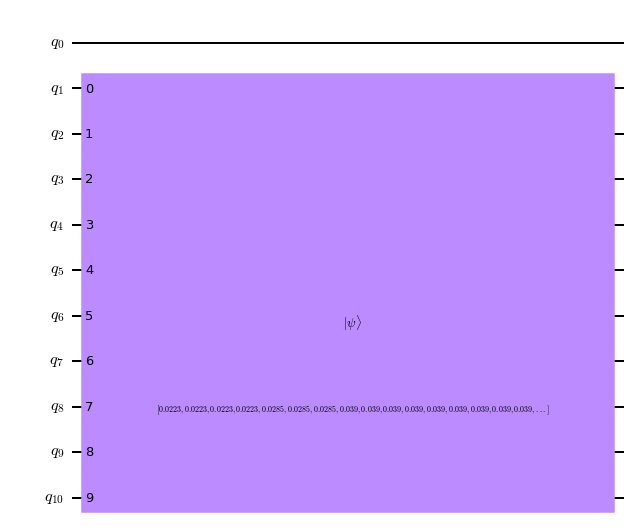

In [463]:
# horizontal scan circuit
qc_h = QuantumCircuit(total_qb)
qc_h.initialize(image_norm_h, range(1, total_qb))
display(qc_h.draw('mpl', fold=-1))

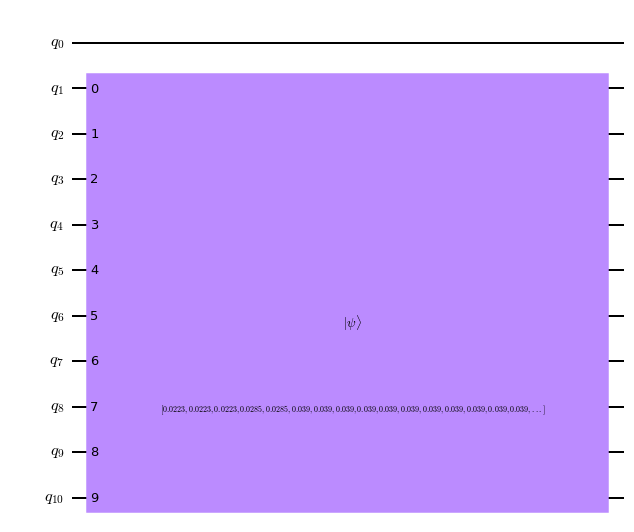

In [464]:
# vertical scan circuit
qc_v = QuantumCircuit(total_qb)
qc_v.initialize(image_norm_v, range(1, total_qb))
display(qc_v.draw('mpl', fold=-1))

## Quantum Hadamard Edge Detection (QHED) ##

### Based on [Paper](https://arxiv.org/abs/1801.01465) ###

$
\newcommand{\ket}[1]{\left|{#1}\right\rangle}
\newcommand{\bra}[1]{\left\langle{#1}\right|}
\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}
$

### Part 1 ###
The first is a simple Hadamard Gate on qubit 0, which is highlighted in red below:

Index 0: $00\color{red}{0}$

Index 1: $00\color{red}{1}$

Index 2: $01\color{red}{0}$

Index 3: $01\color{red}{1}$

Index 4: $10\color{red}{0}$

Index 5: $10\color{red}{1}$

$. . .$
(Example with 3 qubits)

Notice how it alternates, which makes sense when we consider $\mod 2$. This property works neatly with a Hadamard Gate. Recall the definition of a Hamadard Gate:

$
|0 \rangle \rightarrow \frac{(|0 \rangle + |1 \rangle)}{\sqrt{2}} \\
|1 \rangle \rightarrow \frac{(|0 \rangle - |1 \rangle)}{\sqrt{2}}
$

So let's consider applying the Hamadard Gate on the 0th qubit

Peforming this action ($H_0$) on Index 0 (Let's donate this as $I_{2^n - 1}[0]$) yields:

$ \frac{1}{\sqrt{2}} $ $c_0 |000 \rangle + c_0 |001 \rangle)$

$H_0$ on $I_{2^n - 1}[1]$ yields:

$ \frac{1}{\sqrt{2}} $ $c_1 |000 \rangle - c_1 |001 \rangle)$

$H_0$ on $I_{2^n - 1}[2]$ yields:

$ \frac{1}{\sqrt{2}} $ $c_2 |010 \rangle + c_2 |010 \rangle)$

The signs will alternate, because the 0th bit alternates.

Formally, we are performing $I_{2^{n-1}} \otimes H_0$.

The Hadamard Gate $H$ is defined as 

$\tfrac{1}{\sqrt{2}}\begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix}$

$\downarrow$

$
I_{2^{n-1}} \otimes H_0 = \frac{1}{\sqrt{2}}
\begin{bmatrix}
1 & 1 & 0 & 0 & \dots & 0 & 0 \\
1 & -1 & 0 & 0 & \dots & 0 & 0 \\
0 & 0 & 1 & 1 & \dots & 0 & 0 \\
0 & 0 & 1 & -1 & \dots & 0 & 0 \\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
0 & 0 & 0 & 0 & \dots & 1 & 1 \\
0 & 0 & 0 & 0 & \dots & 1 & -1 \\
\end{bmatrix}$

Applying this unitary to the QPIE representation $\ket{\text{Img}} = \sum_{i=0} ^{N-1} c_i \ket{i}$

$
(I_{2^{n-1}} \otimes H_0) \cdot
\begin{bmatrix}
c_0 \\
c_1 \\
c_2 \\
c_3 \\
\vdots \\
c_{N-2} \\
c_{N-1} \\
\end{bmatrix}
\rightarrow \frac{1}{\sqrt{2}}
\begin{bmatrix}
c_0 + c_1 \\
c_0 - c_1 \\
c_2 + c_3 \\
c_2 - c_3 \\
\vdots \\
c_{N-2} + c_{N-1} \\
c_{N-2} - c_{N-1} \\
\end{bmatrix}
$

This matrix gives us access to the gradient between the pixel intensities of neighboring pixels $c_i$ and $c_{i+1}$, through $(c_i - c_{i+1})$.

Intuitively, this should also make sense, again considering the alternating 0th bit between 0/1 and how $H$ changes the sign accordingly.

This Hadamard gate is applied in $\mathcal{O}(1)$ on a quantum computer, allowing us the compute adjacent-cell-differences very quickly, while on a classical computer the same algorithm takes time proportional to the number of pixels, which is $N^2$ or $2^n$.

Time Complexity: $\mathcal{O}(1)$

### Part 2 ###

However, this only obtains the horizontal pixel differences for even-odd pixel pairs, if we examine the matrix closely.

(Highlighted in red below for n = 3 example)
![Even-odd pixel pairs](https://github.com/timothygao8710/Capybaras-Capstone-Project/blob/main/explanation_diagrams/scuffed_even_odd.png?raw=true)

One way to account for this is by performing an amplitude permutation, shifting the entire register right and wrapping around the rightmost element:

![Amp Perm](https://github.com/timothygao8710/Capybaras-Capstone-Project/blob/main/explanation_diagrams/scuffed_amp_permutation.png?raw=true)

^ Amplitude permutation 

![Odd-even pixel pairs](https://github.com/timothygao8710/Capybaras-Capstone-Project/blob/main/explanation_diagrams/scuffed_odd_even.png?raw=true)

^ Result after permutating

This gives us access to also the odd-even pixel pairs now, so we now have all adjacent pixel differences. In post-processing, we can take care not to include irrelevant differences like ($c_5 - c_0$).

We can easily perform this permutation operation with the unitary

$
D_{2^{n+1}} =
\begin{bmatrix}
0 & 1 & 0 & 0 & \dots & 0 & 0 \\
0 & 0 & 1 & 0 & \dots & 0 & 0 \\
0 & 0 & 0 & 1 & \dots & 0 & 0 \\
0 & 0 & 0 & 0 & \dots & 0 & 0 \\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
0 & 0 & 0 & 0 & \dots & 0 & 1 \\
1 & 0 & 0 & 0 & \dots & 0 & 0 \\
\end{bmatrix}
$

In practice, we don't actually rotate. Instead, this unitary just "extends", as follows:
$(c_0, c_0, c_1, c_1, c_2, c_2, \dots, c_{N-2}, c_{N-2}, c_{N-1}, c_{N-1})^T \rightarrow (c_0, c_1, c_1, c_2, c_2, c_3, \dots, c_{N-2}, c_{N-1}, c_{N-1}, c_0)^T$

This is why we need an extra ancillary qubit.

If only we could apply this transformation directly to our quantum state...

Well, it turns out we can! This unitary actually correponds to the Decrement gate. Hence, we can efficently decompose this unitary into a set of single- and multi-controlled-X rotations on a register of multiple qubits as shown by [Fijany and Williams](https://arxiv.org/abs/quant-ph/9809004) and [Gidney](https://algassert.com/circuits/2015/06/12/Constructing-Large-Increment-Gates.html).

In Qiskit, we can use [this function](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.unitary.html) to directly apply the matrix transformation to our quantum state, with .unitary().

So after utilizing the unitary:
$
(I_{2^{n}} \otimes H) \cdot
\begin{bmatrix}
c_0 \\
c_1 \\
c_1 \\
c_2 \\
c_2 \\
c_3 \\
\vdots \\
c_{N-2} \\
c_{N-1} \\
c_{N-1} \\
c_0 \\
\end{bmatrix}
\rightarrow
\begin{bmatrix}
c_0 + c_1 \\
c_0 - c_1 \\
c_1 + c_2 \\
c_1 - c_2 \\
c_2 + c_3 \\
c_2 - c_3 \\
\vdots \\
c_{N-2} + c_{N-1} \\
c_{N-2} - c_{N-1} \\
c_{N-1} + c_0 \\
c_{N-1} - c_0 \\
\end{bmatrix}
$

Now, we have access to the resultant horizontal gradient values $c_i - c_{i+1}$ for all possible pairs of adjacent qubits.

Time Complexity: $\mathcal{O}(n)$ from applying the unitary.

In [465]:
# Initialize the amplitude permutation unitary
D2n_1 = np.roll(np.identity(2**total_qb), 1, axis=1)

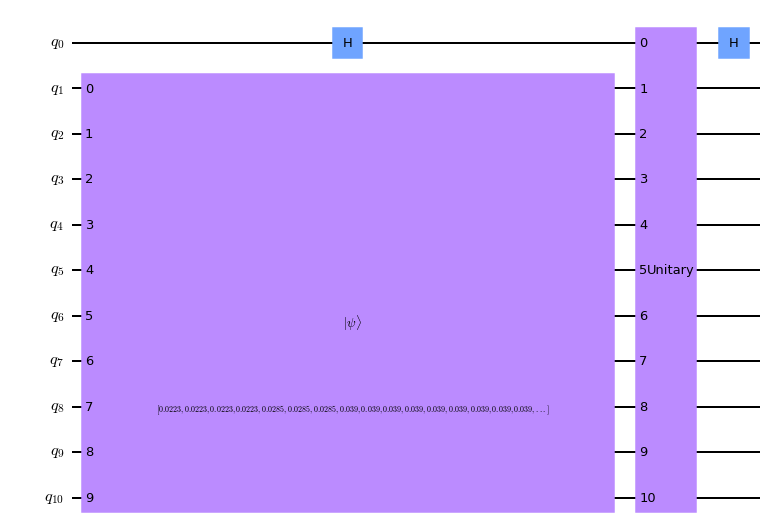

In [466]:
#QHED for horizontal scan circuit
qc_h.h(0)
qc_h.unitary(D2n_1, range(total_qb))
qc_h.h(0)
display(qc_h.draw('mpl', fold=-1))

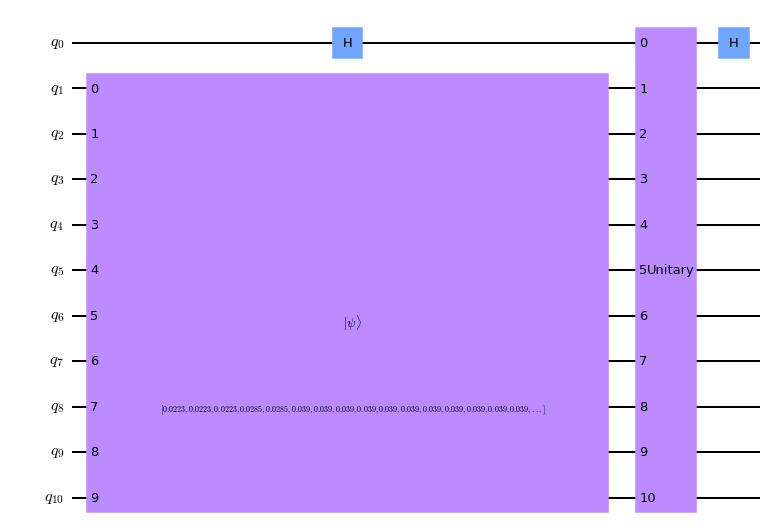

In [467]:
#QHED for vertical scan circuit
qc_v.h(0)
qc_v.unitary(D2n_1, range(total_qb))
qc_v.h(0)
display(qc_v.draw('mpl', fold=-1))

In [468]:
# Store both circuits in a list, so we can run both circuits in one simulation later
circ_list = [qc_h, qc_v]

## Statevector Quantum Simulation ##

In [469]:
# Simulating the circuits
back = Aer.get_backend('statevector_simulator')
results = execute(circ_list, backend=back).result()
sv_h = results.get_statevector(qc_h)
sv_v = results.get_statevector(qc_v)

# Classical Postprocessing

To use our results from QHED, we mark notable edges by "thresholding", i.e., marking cells that have significant adjacent differences as edges.

We store the marked/unmarked cells as a binary value (1 for marked, 0 for unmarked).

We use $2 \cdot i + 1$ to select only indices where it's subtraction between adjacent cells (which we care about) and not the addition.

Also, we take care not to include indices where $i + 1 \mod N = 0$ because that is where $c_{N-1} - c_0$ occurs.

Finally, we can combine our vertical transposed image results with the horizontal original image results with a simple OR operator.


Initially, we used absolute thresholding - we always used the value $10^{-15}$ - the value we found in literature.

This works fine for certain images, and fine for most 32x32 images, which we were originally testing. 

However, as we implemented image gridding (See Main_Pipeline.py) for larger images, we realized absolute thresholding is only a temporary solution. For more details on this part, check out our video, in the problems we faced section. Essentially, we realized that between images, since the value $\sum _{} ^{} c_i^2$ can be drastically different (especially for larger images), and the distribution of $c_{i-1} - c_{i}$ values can also vary between images. As a result, although QPIE maintains the relative difference between pixels, it does not maintain the absolute difference (i.e., a two pixel difference is larger for smaller values of $\sum _{} ^{} c_i^2$, thus it does not make sense for us to threshold by a set absolute value. In our results, this is why we saw that our algorithm works fine for some images but not for others.

To solve this problem, we invented two strategies to threshold adaptively (according to the $\sum _{} ^{} c_i^2$ of image):

- K-Best Adaptive Thresholding
    - In the final cumulated results of all the $c_{i-1} - c_{i}$ differences, we take the $K$ best (largest absolute value) differences and treat them as edges
    - In practice, this value of $K$ is a percentage for how many values we turn into edges in the final images, and the actual $K$ is computed on the fly via multiplying by size of $c_i$ difference array
    - Effectively, this allows us to account for differences in $\sum _{} ^{} c_i^2$ between these differences will scale the entire array of $c_{i-1} - c_{i}$ differences evenly
- Max Adaptive Thresholding
    - In the final cumulated results of all the $c_{i-1} - c_{i}$ differences, we take all values $\leq K \cdot (max \space c_{i-1} - c_{i})$ where $K$ is some percentage
    - Effectively, this allows us to account for differences in $\sum _{} ^{} c_i^2$ between these differences will scale $max \space c_{i-1} - c_{i}$ accordingly
    
We found that both Thresholding methods are useful under different circumstances, but $K=0.2 (20\%)$ K-Best Adaptive Thresholding works best for general cases. Now, with these strategies, we can now tackle any image of any size. Image gridding, adaptive thresholding, and everything else is implemented in the Main_Pipeline.py file. This notebook does not including image gridding but instead takes averages of $N / g$ side length squares, where $g$ is the desired grid size for computation.

8.192149763520472e-19


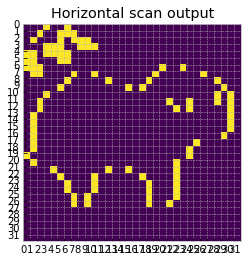

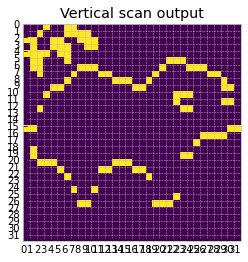

Text(0, 0.5, 'Frequency')

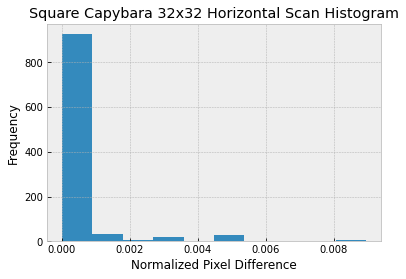

In [470]:
# Classical postprocessing for plotting the output

percent_edges = 0.2

# #Max adaptive thresholding
# thresh = np.max(np.array([np.abs(sv_h[2*i+1].real) for i in range(N*N)])) * (1 - percent_edges)

#K-Best adaptive thresholding
thresh = np.sort(np.array([np.abs(sv_h[2*i+1].real) for i in range(N*N)]))[int(N * N * (1 - percent_edges))]
print(thresh)

# Defining a lambda function for thresholding difference values
threshold = lambda amp: (amp > thresh or amp < -1 * thresh)

# Selecting odd states from the raw statevector and
# reshaping column vector of size 64 to an 8x8 matrix

edge_scan_h = np.abs(np.array([1 if threshold(sv_h[2*i+1].real) and (i + 1) % N != 0 else 0 for i in range(N*N)])).reshape(N, N)
edge_scan_v = np.abs(np.array([1 if threshold(sv_v[2*i+1].real) and (i + 1) % N != 0 else 0 for i in range(N*N)])).reshape(N, N).T

# Plotting the Horizontal and vertical scans
plot_image(edge_scan_h, 'Horizontal scan output')
plot_image(edge_scan_v, 'Vertical scan output')

plt.hist(
    np.array(
        [np.abs(sv_h[2*i+1].real) for i in range(N*N)]
    )
)

plt.title("Square Capybara 32x32 Horizontal Scan Histogram")
plt.xlabel("Normalized Pixel Difference")
plt.ylabel("Frequency")
# plt.hist(
#     np.array(
#         [np.abs(sv_h[2*i+1].real) for i in range(N*N)]
#     )
# )

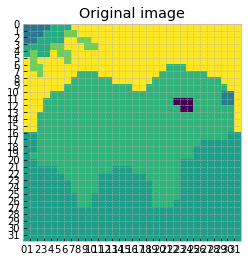

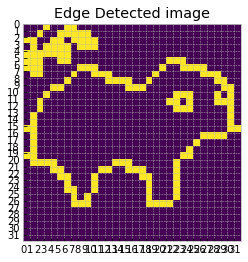

In [471]:
# Combining the horizontal and vertical component of the result
edge_scan_sim = edge_scan_h | edge_scan_v

# Plotting the original and edge-detected images
plot_image(img, 'Original image')
plot_image(edge_scan_sim, 'Edge Detected image')

# Quantum Part - Hardware #

In [445]:
# load account
IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-08-02 13:16:11,632: Credentials are already in use. The existing account in the session will be replaced.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [446]:
# get provider and backend
provider = IBMQ.get_provider(hub='ibm-q', group='open')

backend = least_busy(provider.backends(filters=lambda x: int(x.configuration().n_qubits) >= 7 and 
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

least busy backend:  ibm_oslo


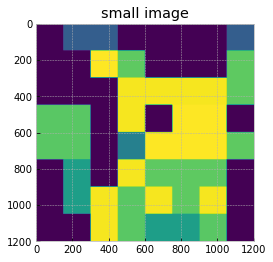

In [449]:
N = 8

#Name the image
name = "Pikachu"
path = os.path.join("test_images", "8bit.png")
img_small = np.asarray(Image.open(path).convert('L'),dtype=int)

# plot image
plot_image(img_small, "small image")

In [450]:
# initialize number of qubits
data_qb = 6
anc_qb = 1
total_qb = data_qb + anc_qb

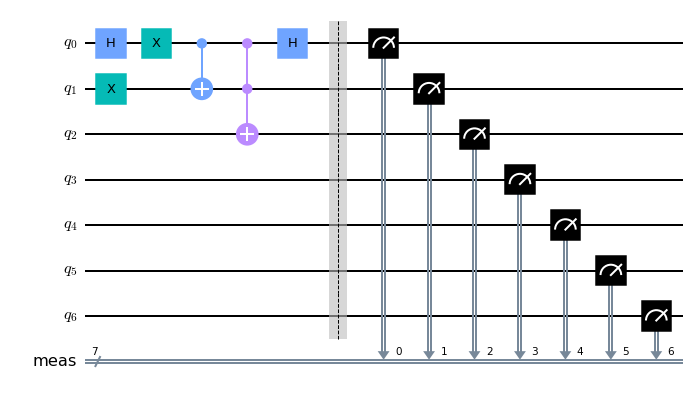

In [451]:
#Evyerthing below here needs to be changed since we're enow using 8x8 not 2x2

# horizontal scan circuit
qc_small_h = QuantumCircuit(total_qb)

# Beginning of Resource Estimation (Time)
start_gates = perf_counter()

qc_small_h.x(1)
qc_small_h.h(0)

# decrement gate - start
qc_small_h.x(0)
qc_small_h.cx(0, 1)
qc_small_h.ccx(0, 1, 2)
# finished decrementing gate

qc_small_h.h(0)
qc_small_h.measure_all()
display(qc_small_h.draw('mpl'))

# End of Resource Estimation (Time)
end_gates = perf_counter()


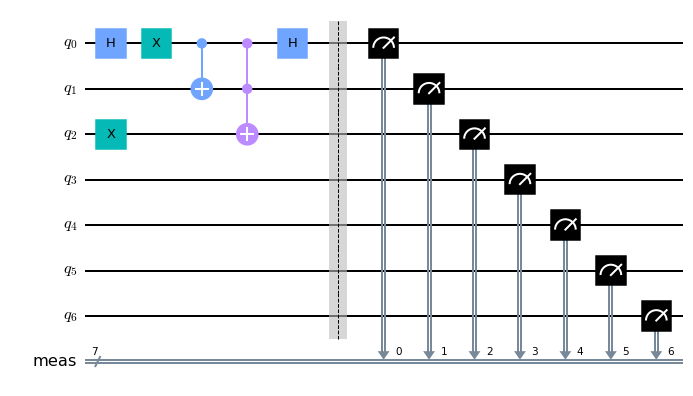

In [452]:
# vertical scan circuit
qc_small_v = QuantumCircuit(total_qb)
qc_small_v.x(2)
qc_small_v.h(0)

# decrement gate - START
qc_small_v.x(0)
qc_small_v.cx(0, 1)
qc_small_v.ccx(0, 1, 2)
# decrement gate finished

qc_small_v.h(0)
qc_small_v.measure_all()
display(qc_small_v.draw('mpl'))

# combine circuits
circ_list = [qc_small_h, qc_small_v]

In [25]:
# transpile circuits to optimize execution (Plus Resource Estimation)
start_t = perf_counter()
qc_small_h_t = transpile(qc_small_h, backend=backend, optimization_level=3)
end_t = perf_counter()

qc_small_v_t = transpile(qc_small_v, backend=backend, optimization_level=3)

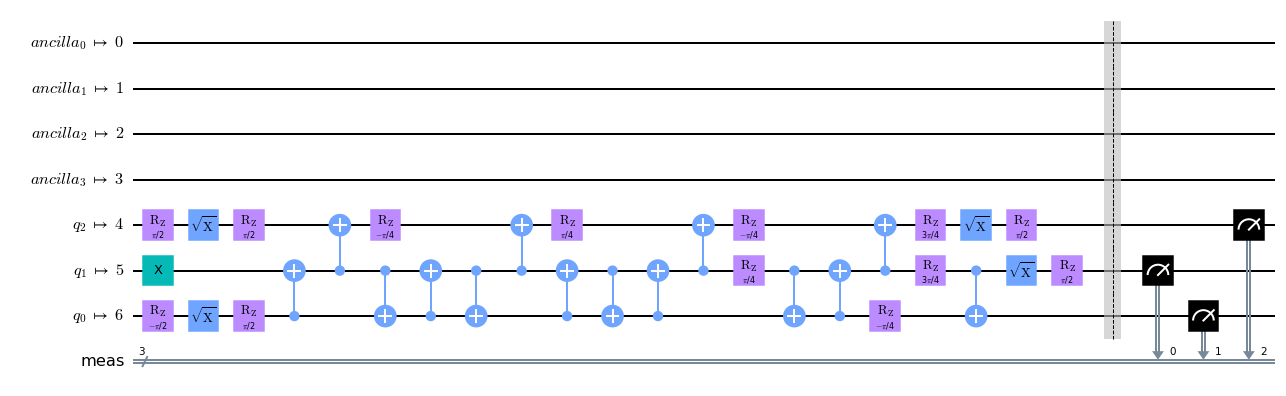

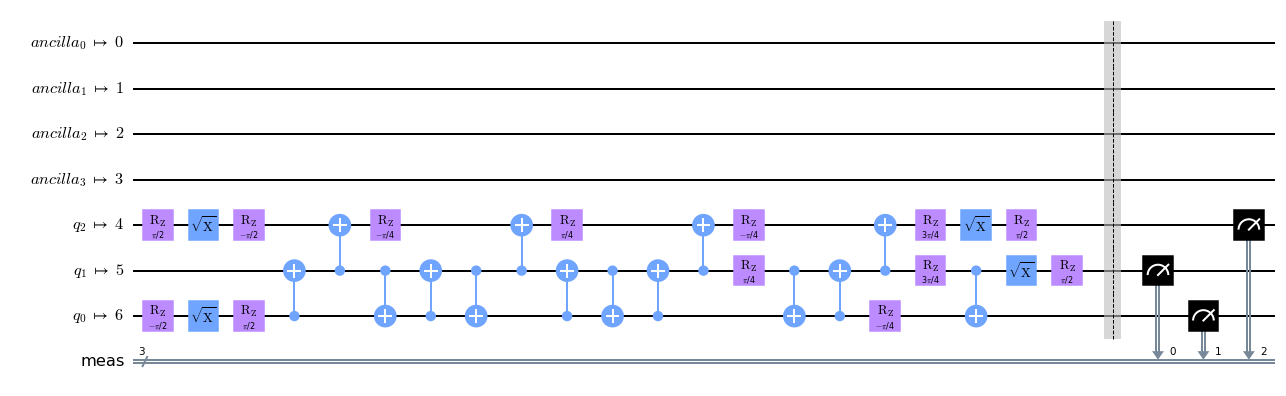

In [26]:
# combine into list
circ_list_t = [qc_small_h_t, qc_small_v_t]

# draw transpiled circuit
display(circ_list_t[0].draw('mpl', fold=-1))
display(circ_list_t[1].draw('mpl', fold=-1))

In [27]:
#Print Resource Estimation Results
print('Resource Estimation Results:')

print(f"Construction took {(end_gates - start_gates)} sec.")
print(f"Width of Circuit: {len(h_active_qubits)} qubits")
print(f"Depth of Circuit: {qc_small_h.depth()}")
print(f"Gate counts: {qc_small_h.count_ops()}")
print(f"Compiling and optimizing took {(end_t - start_t)} sec.")

sim = AerSimulator.from_backend(backend)
result = sim.run(qc_small_h).result()
counts = result.get_counts(qc_small_h)
for(measured_state, count) in counts.items():
    big_endian_state = measured_state[::-1]
    print(f"Measured {big_endian_state} {count} times.")


Resource Estimation Results:
Construction took 0.16961400001309812 sec.
Width of Circuit: 3 qubits
Depth of Circuit: 6
Gate counts: OrderedDict([('measure', 3), ('x', 2), ('h', 2), ('cx', 1), ('ccx', 1), ('barrier', 1)])
Compiling and optimizing took 1.69962039985694 sec.
Measured 010 222 times.
Measured 110 217 times.
Measured 100 278 times.
Measured 000 279 times.
Measured 011 8 times.
Measured 101 4 times.
Measured 001 9 times.
Measured 111 7 times.


In [28]:
job = execute(circ_list_t, backend=backend, shots=8192)
job_monitor(job)

Job Status: job is queued (16)    

In [ ]:
result = job.result()
counts_h = result.get_counts(qc_small_h)
counts_v = result.get_counts(qc_small_v)

print('Counts for horizontal scan:')
display(plot_histogram(counts_h))

print("\n\nCounts for vertical scan:")
display(plot_histogram(counts_v))

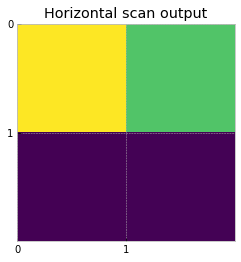

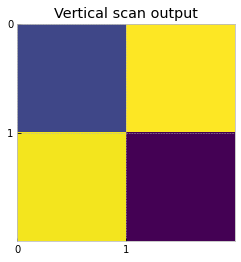

In [ ]:
# Extracting counts for odd numbered states
edge_scan_small_h = np.array([counts_h[f'{2*i+1:03b}'] for i in range(2 ** data_qb)]).reshape(2, 2)
edge_scan_small_v = np.array([counts_v[f'{2*i+1:03b}'] for i in range(2 ** data_qb)]).reshape(2, 2).T

plot_image(edge_scan_small_h, 'Horizontal scan output')
plot_image(edge_scan_small_v, 'Vertical scan output')

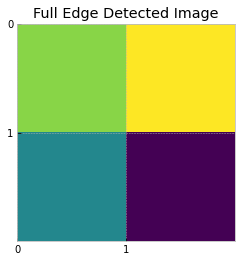

In [ ]:
edge_detected_image_small = edge_scan_small_h + edge_scan_small_v

# plotting original and edge detected images
plot_image(edge_detected_image_small, 'Full Edge Detected Image')